In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
nomeFruta = input("Fruta? ")

Fruta? manga


In [3]:
with open("Calibracao_hsv_" + nomeFruta + ".txt") as hsv:
    
    parametros = hsv.readlines()
          
    hMin = int(parametros[0])
    sMin = int(parametros[1])
    vMin = int(parametros[2])
        
    hMax = int(parametros[3])
    sMax = int(parametros[4])
    vMax = int(parametros[5])

arquivo com as coordenadas de segmentação do pedunculo
*
*
*
*
*
*
*



In [4]:
def segmentacaoHSV(imgCorte):
    
    baixo = np.array([2, 67, 149])
    alto =  np.array([27, 131, 228])

    img_hsv = cv2.cvtColor(imgCorte, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(img_hsv, baixo, alto)

    img_seg = cv2.bitwise_and(imgCorte, imgCorte, mask = mask)
    
    return img_seg

In [5]:
def cantosEncontrados(imgSegBGR):
    
    gray = cv2.cvtColor(imgSegBGR, cv2.COLOR_BGR2GRAY)
    
    largura = imgSegBGR.shape[0]
    altura  = imgSegBGR.shape[1]
    
    centroX = round(largura / 2)
    centroY = round(altura / 2)

    todas_coordenadas  =  [] #Guarda todas as coordenadas (eixo X e Y)
    todas_coordenadasX =  [] #Guarda as coordenadas do eixo X vindas dos cantos encontrados
    todas_coordenadasY =  [] #Guarda as coordenadas do eixo Y vindas dos cantos encontrados

    try:
        
        cornersPonto = cv2.goodFeaturesToTrack(gray, 20, 0.2, 0.25) #Função responsavel por encontrar os cantos Harrys

        for item in cornersPonto:

            x,y = item[0]

            todas_coordenadas.append((x,y))
            todas_coordenadasX.append(int(x))
            todas_coordenadasY.append(int(y))
            #cv2.circle(imgSegBGR, (int(x),int(y)), 1, (0,0,255))

        return todas_coordenadas,todas_coordenadasX, todas_coordenadasY
    
    except TypeError:
        
        todas_coordenadas,todas_coordenadasX, todas_coordenadasY = [(centroX, centroY)], [(centroX)], [(centroY)]
        
        return todas_coordenadas,todas_coordenadasX, todas_coordenadasY
        

# Funções para encontrar o ponto de partida

## Média com peso

In [25]:
#Funções

#Calcula o peso das coordenadas

def calculaPesoY(a):
    
    calPeso = (a[0] * a[0]) + (a[1] * a[1])
    
    calPeso = np.sqrt(calPeso)
    
    calPeso = int(calPeso)
    
    return calPeso

def calculaPesoX(a, centro):
    
    if(a[0] > centro):
        
        dif = (centro - a[0])
        
        soma = a[0] + dif
        
    else:
        
        soma = a[0]
        
    calPeso = (soma * soma) + (a[1] * a[1])
    
    calPeso = np.sqrt(calPeso)
    
    calPeso = round(calPeso)
    
    return calPeso



#Faz a combinação entre a coordenadas e os pesos

def combinacao(peso: list, todas_coordenadasN: list) -> list:
    
    assert len(peso) == len(todas_coordenadasN)
 
    n = len(peso)
    
    combi = []
 
    for i in range(n):
        
        combi.append((peso[i], todas_coordenadasN[i]))
         
    return combi

#Calcula a media dos pontos

def calculaMedia(m):
    
    calMedia = (m[0] *  m[1])
    
    calMedia = int(calMedia)
    
    return calMedia

In [26]:
def encontrarPontos(img, todasCoordenadas, coordenadasX, coordenadasY):
    
    pesoY =   []
    pesoX =   []
    mediaX =  []
    mediaY =  []
    
    centro =  img.shape[0] / 2
    centro = int(centro)
     
    #Calcula o peso de Y
    for i in todasCoordenadas:

        aux = calculaPesoY(i)

        pesoY.append(aux)

    #Calcula o peso de X
    for i in todasCoordenadas:

        aux = calculaPesoX(i, centro)

        pesoX.append(aux)

    #Somatorio do peso Y
    somatorioPesoY = sum(pesoY)

    #Somatoria do pedo X
    somatorioPesoX = sum(pesoX)

    #Realiza combinação
    combinacaoX = combinacao(pesoX, coordenadasX)
    combinacaoY = combinacao(pesoY, coordenadasY)

    #Calcula a media dos pontos X
    for i in combinacaoX:

        aux = calculaMedia(i)

        mediaX.append(aux)

    #Calcula a media dos pontos Y
    for i in combinacaoY:

        aux = calculaMedia(i)

        mediaY.append(aux)


    somatorioX =  sum(mediaX)
    somatorioY =  sum(mediaY)

    pontoX = (somatorioX / somatorioPesoX)  
    pontoY = (somatorioY / somatorioPesoY)

    pontoX = int(pontoX)
    pontoY = int(pontoY)

    return pontoX, pontoY

# Encontra ponto final

In [27]:
def marca_ponto(img, ponto_y, ponto_x):
    
    #minimo = [45, 45, 45]
    #maximo = [180, 180, 180]
    
    minimo = [61, 167, 155]
    maximo = [71, 177, 165]
    
    controle = 0
    
    #Verifica se os valores de um determinado pixel é maior que o RGB(100, 120, 40)
    
    if np.any(img[int(ponto_y), int(ponto_x)] >= minimo):
        
        if np.any(img[int(ponto_y), int(ponto_x)] <= maximo):
             
            controle = 1        
    else:
        
        controle = 0
        
    return controle

In [28]:
def localizaPonto(img, pontoY, pontoX):
    
    copiaX, copiaY = pontoX, pontoY
    
    largura = img.shape[0]
    altura  = img.shape[1]
        
    larguraCentro = largura / 2
    alturaCentro  = altura /  2
    
    limiteBusca = larguraCentro
    
    #montar quadrante
    
    if(pontoX <= larguraCentro and pontoY <= alturaCentro):
        
        movimentoX, movimentoY = 1, 1
        
    elif(pontoX > larguraCentro and pontoY < alturaCentro):
        
        movimentoX, movimentoY = -1, 1
        
    elif(pontoX < larguraCentro and pontoY > alturaCentro):
        
        movimentoX, movimentoY = 1, -1
        
    else:
        
        movimentoX, movimentoY = -1, -1
    
    qtdBusca = 0
    
    while(1):
        
        try:
    
            coordenada = marca_ponto(img, round(pontoY), round(pontoX))

            if(coordenada == 1):

                pontoY, pontoX = pontoY, pontoX

                return int(pontoY), int(pontoX) 

            elif(qtdBusca >= limiteBusca):

                return int(copiaY), int(copiaX)

            elif(pontoX == largura - 5 or pontoY == altura - 5):

                pontoX, pontoY = copiaX, copiaY

            else:

                pontoX, pontoY = pontoX + movimentoX, pontoY + movimentoY

            qtdBusca = qtdBusca + 1

            
        except IndexError:
            
            return int(alturaCentro), int(larguraCentro)


# Identificação

In [31]:
#cap = cv2.VideoCapture(1)

while True:

    #ret, frame = cap.read()
    
    frame = cv2.imread("normal111.jpg")
    hsv =  cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    imgPedunculo = np.copy(frame)

    lim_inf = np.array([hMin, sMin, vMin])
    lim_sup = np.array([hMax, sMax, vMax])
        
    color_mask = cv2.inRange(hsv, lim_inf, lim_sup)

    (couts,hir) = cv2.findContours(color_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    idx = 0
  
    for cout in couts:
        
        area = cv2.contourArea(cout)

        if (area > 600):
            
            idx = idx + 1

            x,y,w,h = cv2.boundingRect(cout)
            frame = cv2.rectangle(frame, (x,y),(x+w,y+h),(0,0,255),2)
            
            xt = x
            xb = x+w
            yt = y
            yb = y+h

            #Regiao de interesse

            Lmax = abs(xt - xb)
            Hmax = abs(yt - yb)

            RoiL = 0.5 * Lmax
            RoiH = 0.5 * Hmax

            #Esses coordenadas são as que vão delimitar a area onde a imagem vai ser cortada

            centro = (xb + xt) / 2

            centroCaixa = RoiL / 2

            x1 = centro - centroCaixa
            x2 = centro + centroCaixa

            y1 = abs(yt - 5)
            y2 = abs(RoiH - y1)
            
            centerPointX = (x1 + x2) / 2
            centerPointY = (y1 + y2) / 2
            
            centerPointX = int(centerPointX)
            centerPointY = int(centerPointY)
            
            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)
            
            TopLeftX = x1
            TopLeftY = y2
                        
            #print(TopLeftX, TopLeftY)
            
            corte = imgPedunculo[y2:y1, x1:x2]
            
            cv2.putText(frame, (str(idx)), (x1, y2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255))
            
            cv2.imwrite(str(idx) + ".jpg", corte)
                   
            cv2.rectangle(frame, (x2, y2), (x1,y1), (255,255,0), 1)
            
            corteHSV = segmentacaoHSV(corte)
                        
            cantos = cantosEncontrados(corteHSV)
            
            todas, x, y = cantos[0], cantos[1], cantos[2]
            
            pontos = encontrarPontos(corteHSV, todas, x, y)
            
            pontoPartidaX, pontoPartidaY = pontos[0], pontos[1]
                        
            pontoFinal = localizaPonto(corteHSV, pontoPartidaY, pontoPartidaX)
            
            pontoFinalX, pontoFinalY = pontoFinal[1], pontoFinal[0]
                    
            pontoFinalX = TopLeftX + pontoFinalX
            pontoFinalY = TopLeftY + pontoFinalY
                                
            cv2.circle(corteHSV, (pontoPartidaX, pontoPartidaY), 1, (255, 0, 255))
            cv2.circle(corteHSV, (pontoFinalX, pontoFinalY), 2, (0, 0, 255))
            
            cv2.circle(frame, (pontoFinalX, pontoFinalY), 2, (0, 0, 255))
            
            cv2.imshow(str(idx) + "ROI HSV", corteHSV)            
                        

    cv2.imshow('Identificacao por HSV', frame) 
    cv2.imwrite("IdentificacaoHSV.jpg", frame)
   
    if cv2.waitKey(1) == 27:
        break

cv2.destroyAllWindows()
#cap.release()    

In [50]:
teste = cv2.imread("pedunculos/nome.png")

In [52]:
cantosEncontrados(teste)

([(38.0, 84.0),
  (29.0, 61.0),
  (63.0, 67.0),
  (20.0, 67.0),
  (41.0, 20.0),
  (10.0, 78.0),
  (21.0, 2.0),
  (66.0, 66.0),
  (40.0, 79.0),
  (3.0, 78.0),
  (46.0, 41.0),
  (8.0, 76.0),
  (43.0, 19.0),
  (72.0, 57.0),
  (69.0, 77.0),
  (44.0, 39.0),
  (71.0, 84.0),
  (20.0, 65.0),
  (44.0, 37.0)],
 [38, 29, 63, 20, 41, 10, 21, 66, 40, 3, 46, 8, 43, 72, 69, 44, 71, 20, 44],
 [84, 61, 67, 67, 20, 78, 2, 66, 79, 78, 41, 76, 19, 57, 77, 39, 84, 65, 37])

In [53]:
testeCoordenadas = cantosEncontrados(teste)

xyt, xt, yt = testeCoordenadas[0], testeCoordenadas[1], testeCoordenadas[2]

In [54]:
encontrarPontosT = encontrarPontos(teste, xyt, xt, yt)

ponto1, ponto2 = encontrarPontosT[0], encontrarPontosT[1]

In [55]:
pontosT = localizaPonto(teste, ponto2, ponto1)

pontoT1, pontoT2 = pontosT[0], pontosT[1]

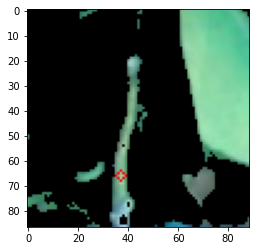

In [56]:
cv2.circle(teste, (pontoT1, pontoT2), 2, (255,0,0))

plt.imshow(teste)
plt.show()

In [57]:
img = cv2.imread("1.jpg")

def corCanal(img):

    corProcuradaBlueMin  = 110
    corProcuradaGreenMin = 140
    corProcuradaRedMin   = 160

    corProcuradaBlueMax  = 140
    corProcuradaGreenMax = 180
    corProcuradaRedMax   = 230

    altura, largura, canal = img.shape

    for x in range(0, largura):

        for y in range(0, altura):

            b,g,r = img[y, x]

            if(b >= corProcuradaBlueMin  and b <= corProcuradaBlueMax   and 
               g >= corProcuradaGreenMin and g <= corProcuradaGreenMax  and 
               r >= corProcuradaRedMin   and r <= corProcuradaRedMax):

                img[y, x] = [b,g,r]
                
                a = 1

            else:

                img[y,x] = 0
                
                b = 0
                
    plt.imshow(img)
    plt.show
                
    if(a == 1):
        return 1
    else:
        return 0
        

1

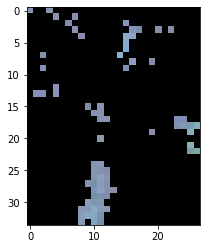

In [58]:
corCanal(img)

•Se o ponto de partida for maior que o centro da imagem, o deslocamentodeve ocorrer da direita para a esquerda.

•Se o ponto de partida for menor que o centro da imagem, o deslocamentodeve ocorrer da esquerda para a direita.

•O deslocamento sempre deve ocorrer de cima para baixo, exceto quando o limite de margem maximo de y for alcancado.

•O deslocamento no eixo x deve acontecer ate alcancar o canto maximo,ou o canto minimo encontrado. Se não o centro da imagem deve ser escolhido como novo ponto de partida.

•O  deslocamento  ́e  realizado  enquanto  o  n ́umero  da  busca  for  menor  ou igual a equacao da busca:
    Eq3. = (L / 2) + 5, onde L  ́e a lagura da imagem
    
•Se o a quantidade de busca for maior que Eq3.   ́e considerado o ponto departida como ponto de corte